# Phase 3 Classification Project - NYC Cycling Fatalities 

## Business Problem and Overview

   Our proposed client is the City of New York itself. The city government has come under fire from constituents and cyclist advocacy groups for the dangerous conditions cyclists endure. The city's transportation leadership want to know what conditions lead to deadly traffic collisions for New York's cyclists. The classification model in this instance is not the end product, as once the city has a record of the accident, they already know if a cyclist has died or not. The final product of this analysis will be the emergent patters revealed by what parameters make for a classification model capable of predicting fatal cycling accidents.
   
   Fittingly, the City of New York is also the source of our data. Our dataset comes in the form of 1.8 million rows detailing motor vehicle collisions that have occured in NYC. The city publishes this data via the NYC Open Data project, an initiative undertaken by the city to make publicly aggregated data accessible to citizens. The data spans nearly a decade, covering dates from July 2012, and is updated almost daily. 
   
   Our dataset is highly imbalanced (99.5% - .5%) which means that using accuracy score as a default would be a mistake, as even a dummy model that simply guessed the majority class every time would have an accuracy of 99.5%. For our purposes, a metric such as recall would work much better, as judging our model on its ability to find the true positives (lethal collisions). 

## 1. Data Understanding

### 1.1 Import the Relevant Libraries, Modules, and Functions

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.metrics import plot_confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from category_encoders.count import CountEncoder

from imblearn.over_sampling import SMOTE

# This pandas option makes sure the juptyer notebook displays all the columns 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

seed = 6

### 1.2 CSV Into Pandas Dataframe

In [2]:
# Here we read our csv into a pandas dataframe. This can take a while. 
df = pd.read_csv('../data/Motor_Vehicle_Collisions.csv', low_memory=False)

In [3]:
# df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1830092 entries, 0 to 1830091
Data columns (total 29 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   CRASH DATE                     object 
 1   CRASH TIME                     object 
 2   BOROUGH                        object 
 3   ZIP CODE                       object 
 4   LATITUDE                       float64
 5   LONGITUDE                      float64
 6   LOCATION                       object 
 7   ON STREET NAME                 object 
 8   CROSS STREET NAME              object 
 9   OFF STREET NAME                object 
 10  NUMBER OF PERSONS INJURED      float64
 11  NUMBER OF PERSONS KILLED       float64
 12  NUMBER OF PEDESTRIANS INJURED  int64  
 13  NUMBER OF PEDESTRIANS KILLED   int64  
 14  NUMBER OF CYCLIST INJURED      int64  
 15  NUMBER OF CYCLIST KILLED       int64  
 16  NUMBER OF MOTORIST INJURED     int64  
 17  NUMBER OF MOTORIST KILLED      int64  
 18  CO

### 1.3 Seperating by Cyclist Fatalities, Cyclist Injuries and Finding Distributions

In [4]:
# Lets start by finding how many collisions involved a cyclist, fatally or otherwise. 
cyclist_collisions = df.loc[ (df['NUMBER OF CYCLIST INJURED'] > 0) | (df['NUMBER OF CYCLIST KILLED'] > 0)]
len(cyclist_collisions)

43280

In [5]:
# This df is comprised of collisions where one or more cyclist were injured, but none died. 
non_lethal_collisions = df.loc[(df['NUMBER OF CYCLIST INJURED'] > 0) & (df['NUMBER OF CYCLIST KILLED'] == 0)]
len(non_lethal_collisions)

43101

In [6]:
# Next lets find how many rows record a cyclist dying. 
lethal_collisions = df.loc[df['NUMBER OF CYCLIST KILLED'] > 0]
len(lethal_collisions)

179

In [7]:
# Here we are determining how many collisions resulted in both cyclist injuries, and cyclist fatalities. 
combination_collisions = df.loc[ (df['NUMBER OF CYCLIST INJURED'] > 0) & (df['NUMBER OF CYCLIST KILLED'] > 0) ]
len(combination_collisions)

7

In [8]:
# Only one row details an event where more than one cyclist died.
print(len(df.loc[df['NUMBER OF CYCLIST KILLED'] > 1]))

# This row describes the tragic terrorist attack that occured on Halloween 2017.
df.loc[df['NUMBER OF CYCLIST KILLED'] == 2]

1


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
687327,10/31/2017,15:08,MANHATTAN,10014,40.729046,-74.01073,"(40.729046, -74.01073)",WEST STREET,WEST HOUSTON STREET,NaN,12.0,8.0,7,6,1,2,4,0,Other Vehicular,Unspecified,Unspecified,Unspecified,Unspecified,3782508,Flat Bed,Bus,Bike,Bike,Bike


### 1.4 Counts Analysis 
    
   So out of nearly 2 million recorded traffic collisions, 43,280 involved a cyclist either getting injured, or killed. 
   
   Of those 43,280 collisions involving a cyclist, 43,101 detail a cyclist getting injured, but no cyclists dying. This means that in 99.5% of traffic collisions where a cyclist is either injured or killed, the cyclist does not die of their injuries. This is a HIGHLY imbalanced dataset, and our classifiers will need to be extremely robust to detect the minority class. 
   
   We found 179 rows detailing an incident that resulted in the death of a cyclist. Only 7 rows fell into the category of 'combination collisions' where there were both cyclist injuries, as well as cyclist deaths. These combination rows will be considered lethal collisions in our classification, as they have obvious crossed the threshold for what defines a deadly collision (more than 0 cyclist deaths). 
   
   Only one row in our entire dataset represents an event where more than one cyclist died. This row details the terrorist attack that occured on Halloween of 2017, where an attacker drove a pickup truck down the westside bike path, injuring 12, and killing 8. This tragic event is certainly an outlier in our dataset, and will not be included in our model building process, as anti-terrorist measures on seperated, dedicated bike paths is outside the scope of this project's analysis. In addition, measures to prevent this kind of event from happening again on the west side bike path have already been taken. 

In [9]:
# Isolating just the collisions involving cyclists
cyc_col = df.loc[ (df['NUMBER OF CYCLIST INJURED'] > 0) | (df['NUMBER OF CYCLIST KILLED'] > 0)]

# Dropping the 2017 terror attack from our dataframe
all_cycling_collisions = cyc_col.loc[cyc_col['NUMBER OF CYCLIST KILLED'] < 2]

# Making sure we don't have any collisions recorded twice, by dropping any duplicates in the ID column 
all_cycling_collisions.drop_duplicates(['COLLISION_ID'])

# Checking the length 
len(all_cycling_collisions) 

43279

In [10]:
# We saved our cycling collisions data as its own csv, as this is really the raw dataset of interest. 

#all_cycling_collisions.to_csv('Cycling_Collisions_Isolated')

### 1.6 Column Data and NaN Value Counts

   The first problem with much of the information in this dataset, is that it is stored in messy, irregular strings. For example under vehicle type, we see 'taxi' and 'Taxi' as seperate categories. In the date column, the dates are stored as strings, which will have to be converted, or at the very least one hot encoded into buckets if we want date to be a useful feature. 
   
   The other challenge standing in the way of this analysis is going to be dealing with all the NaN values in columns that we need for our models. With this is mind, there are two reasons why we chose to not simply drop rows with NaN values in important input columns. 

   One is that because our dataset is so incredibly imbalanced, NaN values in important columns, in rows belonging to our minority class, will significantly impede our attempt to generate a generalizable model that can identify the minority class in new unseen data. The other reason we must find a way to deal with the rows containing NaNs is that since the number of lethal collisions is so proportionally small, if we just dropped rows with NaNs in the relevant columns, we would be thinning out our already tiny minority class. 
   
   This means that our process is going to involve a lot of preprocessing, filling in the missing pieces. The first step in that process is to see what the damage is, and look at the NaN value counts for our columns.

### 1.6.1 Time and Location Data Columns


In [11]:
# Displaying the time and location columns 
for i in all_cycling_collisions.columns[:10]:
    print(f'The {i} column is {all_cycling_collisions[i].isna().sum() / len(all_cycling_collisions) * 100}% NaNs') 

The CRASH DATE column is 0.0% NaNs
The CRASH TIME column is 0.0% NaNs
The BOROUGH column is 21.75651008572287% NaNs
The ZIP CODE column is 21.75882067515423% NaNs
The LATITUDE column is 7.48168857875644% NaNs
The LONGITUDE column is 7.48168857875644% NaNs
The LOCATION column is 7.48168857875644% NaNs
The ON STREET NAME column is 14.358002726495528% NaNs
The CROSS STREET NAME column is 27.325030615309963% NaNs
The OFF STREET NAME column is 85.80142794426858% NaNs


### 1.6.2 Contributing Factor Columns

These columns contain data regarding the cause of the accident, which could be critical for our model. We see that after the second column there is a drastic increase in NaN values. 

In [12]:
# Lets examine the contributing factor columns 
for i in all_cycling_collisions.columns[18:23]:
    print(f'The {i} column is {all_cycling_collisions[i].isna().sum() / len(all_cycling_collisions) * 100}% NaNs') 

The CONTRIBUTING FACTOR VEHICLE 1 column is 0.04159060976455094% NaNs
The CONTRIBUTING FACTOR VEHICLE 2 column is 7.125857806326394% NaNs
The CONTRIBUTING FACTOR VEHICLE 3 column is 97.70789528408696% NaNs
The CONTRIBUTING FACTOR VEHICLE 4 column is 99.75276693084406% NaNs
The CONTRIBUTING FACTOR VEHICLE 5 column is 99.91912936990227% NaNs


### 1.6.3 Vehicle Type Code Columns

   These 5 columns contain data about the vehicles that were involved in the collision, including the Bike/E-Bike. Vehicle type could be a super important feature for our models, so we will have to deal with the messy string values, as well as NaN values. 

In [13]:
# Displaying the vehicle type code columns
for i in all_cycling_collisions.columns[24:29]:
    print(f'The {i} column is {all_cycling_collisions[i].isna().sum() / len(all_cycling_collisions) * 100}% NaNs') 

The VEHICLE TYPE CODE 1 column is 0.046211788627278816% NaNs
The VEHICLE TYPE CODE 2 column is 9.08754823355438% NaNs
The VEHICLE TYPE CODE 3 column is 97.73331176783198% NaNs
The VEHICLE TYPE CODE 4 column is 99.75507752027542% NaNs
The VEHICLE TYPE CODE 5 column is 99.91450819103953% NaNs


We can see a sharp decline in the number of rows with vehicle codes going from the second to the third column. The string values, and the NaN values will be dealt with in the data preparation step.

## 2. Data Cleaning

### 2.1 Drop Unnecessary Columns

The first step of preprocessing is to drop the columns that are not useful for this analysis.

In [14]:
# Dropping unwanted columns using this list
all_cycling_collisions = all_cycling_collisions.drop([ 'NUMBER OF PERSONS INJURED',
                                                       'NUMBER OF PERSONS KILLED', 
                                                       'NUMBER OF PEDESTRIANS INJURED',
                                                       'NUMBER OF PEDESTRIANS KILLED',  
                                                       'NUMBER OF MOTORIST INJURED',
                                                       'NUMBER OF MOTORIST KILLED',
                                                       'COLLISION_ID' ] , axis=1)

# Making sure it worked
all_cycling_collisions.shape

(43279, 22)

### 2.2 Making the 'Lethal' Column 

Before we can seperate our training data and our holdout data, we need to make a target y column, as our two datasets currently store this information in two seperate columns. After we have created this new column, we can drop the original two. 

In [15]:
# Creating the lethality column and filling it with zeros
all_cycling_collisions['Lethal'] = 0

# Going through the data frame and marking lethal collisions
all_cycling_collisions.loc[ all_cycling_collisions['NUMBER OF CYCLIST KILLED'] > 0,['Lethal']] = 1

# Dropping the old columns
all_cycling_collisions = all_cycling_collisions.drop(['NUMBER OF CYCLIST KILLED', 'NUMBER OF CYCLIST INJURED'], axis=1)

# The all-important sanity check
all_cycling_collisions['Lethal'].value_counts()

0    43101
1      178
Name: Lethal, dtype: int64

### 2.3 Collision Year 

One of the features we want to include in our modelling process is what year the collision took place in, to do this we are going to create a new column for year, and make sure it is in a format that can be handled by SciKit-learn's OneHotEncoder( ). 

In [16]:
# Creating our year column, so we can One-Hot Encode it in a pipeline later on. 
all_cycling_collisions['Year'] = [int(date[-4:]) for date in all_cycling_collisions['CRASH DATE']]

# Checking our work 
all_cycling_collisions['Year'].value_counts()

2020    5481
2019    4964
2016    4945
2017    4864
2018    4694
2015    4266
2013    4062
2014    3999
2021    3802
2012    2202
Name: Year, dtype: int64

### 2.4 Collision Month

We are creating this column for two reasons. The first is that this information could be a very good predictor of cycling lethality, for example if icy roads contribute to cyclist deaths in the winter months. The other reason is that our models are going to need every feature we can give them if they are going to be able to identify the minority class in spite of the extreme class imbalance. Also fortunate is the fact that every single record in our dataset has an entry for 'CRASH DATE', so we dont have to deal with any NaN values. 

In [17]:
# Creating our 'Month' Column 
all_cycling_collisions['Month'] = [int(date[:2]) for date in all_cycling_collisions['CRASH DATE']]

# Checking the values 
all_cycling_collisions['Month'].value_counts()

8     5768
7     5539
9     5420
6     4819
10    4277
5     3998
11    3068
4     2817
3     2193
12    2146
1     1725
2     1509
Name: Month, dtype: int64

### 2.5 Holiday Column

To take further advantage of the lack of NaN values, we are going to engineer a Holiday Column, that tracks whether or not a collision took place on or very near to a major holiday. Unfortunately, a holiday means a predictable spike in drunk driving, and also just an increase in travel in general. This column will track collisions that took place on the most hazardous holiday travel days. 

In [18]:
# Chopping the year off of the date strings for easier syntax later
all_cycling_collisions['CRASH DATE'] = [date[:5] for date in all_cycling_collisions['CRASH DATE']]

# Making a list of the relevant dates
holiday_travel_dates = ['12/31', '01/01',
                        '05/27', '05/28', '05/29', '05/30',
                        '06/03', '06/04' , '06/05',
                        '09/05', '09/06', '09/07', 
                        '11/24', '11/25', '11/26',
                        '12/24', '12/25', '12/26',
                        '10/31', '11/1']

# Creating the column and filling it with zeros to begin with
all_cycling_collisions['Holiday Collision'] = 0

# Marking the relevant collisions
for date in holiday_travel_dates:
    all_cycling_collisions.loc[all_cycling_collisions['CRASH DATE'] == date, ['Holiday Collision']] = 1
    
# With the last of our 'CRASH DATE' based feature engineering done, we can drop it from our dataframe
all_cycling_collisions = all_cycling_collisions.drop(['CRASH DATE'], axis=1)
    
# Sanity check    
all_cycling_collisions['Holiday Collision'].value_counts()

0    41163
1     2116
Name: Holiday Collision, dtype: int64

### 2.6 Time of Day 

The hour of the day the accident occured in could have big implications in our model, and for our business problem. As it stands right now, the 'CRASH TIME' column specifies the time down to the minute, which is a more granular breakdown than our model requires. We will convert the hour and minute information into only what hour the accident occured in. Thankfully, the data is already in a 24 hour format, and there are no NaN values

In [19]:
# Getting just the hour information and storing it in a new column, 'Hour'
all_cycling_collisions['Hour'] = [int(time[:2].replace(':','')) for time in all_cycling_collisions['CRASH TIME']]

# Dropping the 'CRASH TIME' column, as we no longer need it
all_cycling_collisions = all_cycling_collisions.drop(['CRASH TIME'], axis=1)

# Sanity Check
all_cycling_collisions['Hour'].value_counts()

18    3588
17    3558
19    3306
16    3188
20    2932
14    2792
15    2715
13    2449
21    2394
12    2123
22    1825
11    1823
9     1634
8     1562
10    1477
23    1342
0     1307
7      961
6      569
1      514
2      365
5      312
3      279
4      264
Name: Hour, dtype: int64

### 2.7 Borough

Borough could turn out to be a very useful feature for our classification models, but first we have to contend with all the NaN values in that column. We know from our earlier NaN report on this column that roughly a quarter of collisions do not specify what Borough the crash took place in. 

In [20]:
# Looking at the values in the Borough Column 
print(all_cycling_collisions["BOROUGH"].value_counts())

# This dataframe is all of our rows where Borough holds a NaN value
nan_boro = all_cycling_collisions.loc[all_cycling_collisions['BOROUGH'].isna()]

# This line confirms what our NaN report told us earlier, by telling us the amount of NaN's
print(f'''
        There are {len(nan_boro)} rows with a NaN for Borough''')

# This line prints how many of our 9416 rows have latitude and longitude data
len(nan_boro) - nan_boro['LOCATION'].isna().sum()

BROOKLYN         13425
MANHATTAN         9841
QUEENS            6698
BRONX             3496
STATEN ISLAND      403
Name: BOROUGH, dtype: int64

        There are 9416 rows with a NaN for Borough


6966

The above code shows us that even though we have 9416 rows that dont specify Borough, 6966 of those rows do specify Latitude and Longitude data, which we can use to extrapolate what Borough they occured in. (Street name might be easier, or put the zip code thing before this and then use them.)

In [21]:
# Let's start by renaming the column to match the others
all_cycling_collisions['Borough'] = all_cycling_collisions['BOROUGH']
all_cycling_collisions = all_cycling_collisions.drop(['BOROUGH'], axis=1)
#
#
#
#
#
#
# 
#
#
#
#
#

### 2.8 Zip Code 

We definitely want to feed this feature into our model, as it could help our classificaiton algorithm perform better. 

In [22]:
# This is how many rows do not contain Zip Code information
print(sum(all_cycling_collisions['ZIP CODE'].isna()))

# Of those 9417 rows that dont have zipcode data, only 2450 also do not have latitude and longitude 
len(all_cycling_collisions.loc[all_cycling_collisions['ZIP CODE'].isna() & all_cycling_collisions['LOCATION'].isna()])

9417


2450

What the above numbers mean is that if we can find a way to get the zipcode from the Latitude and Longitude, we can fill in three quarters of our missing zip codes. 

In [23]:
# Let's rename our column so we can tell it's been processed 
all_cycling_collisions['Zip Code'] = [zipcode for zipcode in all_cycling_collisions['ZIP CODE'] ]

#
#
#
#
#
#
# ZIP CODE WIZARDY GOES HERE, STACK OVERFLOW PAGE HAS BEEN BOOKMARKED
#
#
#
#
#
#
#

# Now that we are finished with the Location-Based columns, we can drop the originals 
all_cycling_collisions = all_cycling_collisions.drop(['ZIP CODE', 'LATITUDE', 'LONGITUDE', 'LOCATION'], axis=1)

### 2.9 Street Name

If it becomes a strong predictor, street name could be an essential feature for our business problem, as it would tell the city which streets are the most dangerous for cyclists, and therefore where to focus their efforts in terms of building new infrastructure. Street name in our dataset comes in the form of three columns, ON STREET NAME, CROSS STREET NAME, and OFF STREET NAME. The values in these columns are fairly clean in their formatting, and dont exhibit any significant overlap or redundancy.

In [24]:
# This dataframe contains the rows with no street data whatsoever
no_street_data = all_cycling_collisions.loc[all_cycling_collisions['ON STREET NAME'].isna() & 
                                            all_cycling_collisions['CROSS STREET NAME'].isna() &
                                            all_cycling_collisions['OFF STREET NAME'].isna()]

# Luckily only 61 rows of our entire dataframe contain zero street name values
print(f'There are {len(no_street_data)} rows without any street name data.')

There are 61 rows without any street name data.


Now we are finding the columns with NaN values under Cross Street, and filling them in with the values from OFF STREET NAME, if there are any. 

In [25]:
# Renaming our two columns 
all_cycling_collisions['Street'] = all_cycling_collisions['ON STREET NAME']
all_cycling_collisions['Cross Street'] = all_cycling_collisions['CROSS STREET NAME']

# Check how many NaN values we have in Cross Street before meshing it with OFF STREET NAME
print(len(all_cycling_collisions.loc[all_cycling_collisions['Cross Street'].isna()]))

# For our columns without a listed Cross Street, we are using the OFF STREET NAME value, if it has one
all_cycling_collisions.loc[all_cycling_collisions['Cross Street'].isna(), ['Cross Street']] = all_cycling_collisions['OFF STREET NAME']

# Number of NaNs in Cross Street after the merge
print(len(all_cycling_collisions.loc[all_cycling_collisions['Cross Street'].isna()]))

# Drop the old columns 
all_cycling_collisions = all_cycling_collisions.drop(['ON STREET NAME','CROSS STREET NAME','OFF STREET NAME'],axis=1)

11826
5681


### 2.10 Contributing Factor Columns 

Our strategy for these columns is to use the values in the first column as the defaults, then for the rows where the contributing factor is unknown, use the values from the second column to fill in some of the gaps. Because the 3rd, 4th and 5th columns are almost entirely NaN values, we will ignore them. 

In [26]:
# Creating our Factor 1 column using CONTRIBUTING FACTOR VEHICLE 1 as the default value
all_cycling_collisions['Factor 1'] = all_cycling_collisions['CONTRIBUTING FACTOR VEHICLE 1']

# Going through Factor 1, and any rows that equal 'Unspecified', we input the value of CONTRIBUTING FACTOR VEHICLE 2
all_cycling_collisions.loc[all_cycling_collisions['Factor 1'] == 'Unspecified', ['Factor 1']] = all_cycling_collisions['CONTRIBUTING FACTOR VEHICLE 2']

# Dropping the old columns
all_cycling_collisions.drop(['CONTRIBUTING FACTOR VEHICLE 1', 
                             'CONTRIBUTING FACTOR VEHICLE 2',
                             'CONTRIBUTING FACTOR VEHICLE 3', 
                             'CONTRIBUTING FACTOR VEHICLE 4',
                             'CONTRIBUTING FACTOR VEHICLE 5'], 
                                 axis=1, inplace=True)

### 2.11 Vehicle Type Codes 

Unlike some of the other features in this dataset, the Vehicle Type Codes are horrific in their messy, overlapping nature. For example 'VAN', 'Van, and 'van' are all seperate categories. To deal with this we have created a few buckets to sort each string into, that will hopefully give our model more insight into what vehicle type makes for a deadly crash. Each of these new cleaned categories will be a single column, 'Vehicle Type'.

In [27]:
# Creating our column with a default 'Vehicle Type Unknown' string value
all_cycling_collisions['Vehicle Type'] = 'Vehicle Type Unknown'

# Making a list of our vehicle type columns, so we can iterate over them
vehicle_columns = ['VEHICLE TYPE CODE 1',
           'VEHICLE TYPE CODE 2',
           'VEHICLE TYPE CODE 3', 
           'VEHICLE TYPE CODE 4',
           'VEHICLE TYPE CODE 5']

# This dictionary translates the most common vehicle codes into our new categories    
dict = {'Sedan':'Sedan','4 dr sedan':'Sedan','2 dr sedan': 'Sedan', 'Convertible':'Sedan','SEDAN':'Sedan',
        'PASSENGER VEHICLE':'Sedan', 'Station Wagon/Sport Utility Vehicle':'SUV', 
        'SPORT UTILITY / STATION WAGON':'SUV', 'Taxi': 'Taxi', 'TAXI':'Taxi', 
        'LIVERY VEHICLE': 'Taxi', 'VAN':'Work Van', 'SMALL COM VEH':'Work Van', 'Van':'Work Van', 'van':'Work Van', 
        'Pick-up Truck':'Pickup', 'PICK-UP TRUCK':'Pickup', 'Box Truck':'Large Truck', 'LARGE COM VEH':'Large Truck',
        'Tractor Truck Diesel':'Large Truck','Flat Bed':'Large Truck','Tow Truck / Wrecker':'Large Truck', 
        'Tractor Truck Gasoline':'Large Truck','Concrete Mixer':'Large Truck','FIRE TRUCK':'Large Truck',
        'Armored Truck':'Large Truck','TRUCK':'Large Truck','FIRE':'Large Truck', 'E-Scooter':'Scooter',
        'E-Sco':'Scooter', 'Moped':'Scooter','SCOOTER':'Scooter','DELIV':'Scooter', 'Bus':'Bus','BUS':'Bus',
        'School Bus':'Bus', 'Garbage or Refuse':'Large Truck', 'Tanker':'Large Truck'}

# Iterating over our dictionary by key
for i in dict.keys():

    # Iterating over each vehicle column
    for j in vehicle_columns:
    
        all_cycling_collisions.loc[all_cycling_collisions[j] == i, ['Vehicle Type']] = dict[i]
    
# Dropping the old columns
all_cycling_collisions.drop(['VEHICLE TYPE CODE 1',
                             'VEHICLE TYPE CODE 2', 
                             'VEHICLE TYPE CODE 3', 
                             'VEHICLE TYPE CODE 4',
                             'VEHICLE TYPE CODE 5'], 
                              axis=1, inplace=True)

# Checking out the final result
all_cycling_collisions['Vehicle Type'].value_counts()

Sedan                   18302
SUV                     11518
Vehicle Type Unknown     6431
Taxi                     3673
Scooter                  1093
Pickup                    647
Work Van                  628
Bus                       557
Large Truck               430
Name: Vehicle Type, dtype: int64

In [28]:
# Lets take a look at our cleaned dataset
all_cycling_collisions.head()

,Lethal,Year,Month,Holiday Collision,Hour,Borough,Zip Code,Street,Cross Street,Factor 1,Vehicle Type
52,0,2021,4,0,11,QUEENS,11368,NaN,100-10 ROOSEVELT AVENUE,Turning Improperly,SUV
90,0,2021,4,0,0,NaN,NaN,BATH AVENUE,NaN,Failure to Yield Right-of-Way,SUV
139,0,2021,4,0,17,BRONX,10452,GRANT HIGHWAY,UNIVERSITY AVENUE,Pedestrian/Bicyclist/Other Pedestrian Error/Co...,SUV
145,0,2021,4,0,19,BROOKLYN,11201,FLATBUSH AVENUE EXTENSION,JOHNSON STREET,Driver Inattention/Distraction,Sedan
178,0,2021,4,0,0,QUEENS,11369,93 STREET,32 AVENUE,Unsafe Speed,Sedan


## 3. Data Preprocessing

### 3.1 Train Holdout Split, and Train Test Split

The absolute first thing we need to do in terms of preprocessing is to seperate our data into the train and holdout set to avoid data leakage, and make sure we can robustly evaluate our models later on. Then we seperate our training data further into train and test so we can evaluate different model iterations. 

In [29]:
# Seperating our data into features and target
X = all_cycling_collisions.drop(['Lethal'], axis=1)
y = all_cycling_collisions['Lethal']

# Train holdout split
X_training, X_hold, y_training, y_hold = train_test_split(X, y, random_state=seed, test_size=.1)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_training, y_training, random_state=seed, test_size=.2)

### 3.2 Prepping our Data for Modeling

In [30]:
# Setting up a Pipeline for columns we can one-hot encode
ohe_transformer = Pipeline(steps=[
    ('ohe_imp', SimpleImputer(strategy='constant')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))])

# Pipeline 2 for columns we are going to encode in place, and then scale 
ord_transformer = Pipeline(steps=[
    ('ord_imp', SimpleImputer(strategy='constant')),
    ('cat', CountEncoder()),
    ('mms', MinMaxScaler() )])

# These two columns will tell our ColumnTransformer which columns to apply each of the transformers to
one_hots = ['Year', 'Month', 'Holiday Collision', 'Hour', 'Borough','Vehicle Type']
ordinals = ['Zip Code', 'Street', 'Cross Street', 'Factor 1' ]

# Making our preprocessor
preprocessor = ColumnTransformer([
    ('ohe', ohe_transformer, one_hots),
    ('ord', ord_transformer, ordinals)
])

# Running our preprocessor on X_train and X_test
transformed_train = preprocessor.fit_transform(X_train)
transformed_test  = preprocessor.transform(X_test)

# Turning the arrays back into dataframes
X_train_encoded = pd.DataFrame.sparse.from_spmatrix(transformed_train)
X_test_encoded  = pd.DataFrame.sparse.from_spmatrix(transformed_test)

# Sanity Check 
X_test_encoded.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.031821,0.000666,0.001716,1.000000
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.008103,0.001332,0.003677,1.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.038450,0.008659,0.002206,0.434345
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.052151,0.021758,0.000981,0.148181
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.079847,1.000000,-0.000245,0.148181


In [31]:
y_train.head()

1253906    0
941773     0
426120     0
1095555    0
587932     0
Name: Lethal, dtype: int64

In [32]:
y_train.index

Int64Index([1253906,  941773,  426120, 1095555,  587932, 1752885,  117556,
            1360368,  277318, 1790559,
            ...
             769790,  865471, 1808228, 1406883,  281492,  932208,  143806,
             825369,   84979,   60098],
           dtype='int64', length=31160)

In [33]:
y_train = np.array(y_train)

### 3.3 Handling Class Imbalance with SMOTE

Because our dataset is so incredibly imbalanced, we are utilizing Synthetic Minority Oversampling Technique, where we generate new, synthetic minority class data points. We are doing this hoping that when we fit our models to the training data, the synthetic points will make the model more sensitive to the minority class, and more able to pick it up. 

In [34]:
# Length of training data before SMOTE
#print(len(X_train_encoded))

# Instantiating SMOTE and generating our new training sets
#sm = SMOTE(sampling_strategy=.1,random_state=seed)
#X_train_resampled, y_train_resampled = sm.fit_resample(X_train_encoded, y_train)

# Length of training data after SMOTE
#print(len(X_train_resampled))

X_train_resampled = X_train_encoded
y_train_resampled = y_train

## 4. Exploring Model Types

The first step will be an evaluate function to see how each model does. 

In [68]:
def evaluate(classifier):
    
    classifier.fit(X_train_resampled, y_train_resampled)
    y_preds = classifier.predict(X_test_encoded)
    print(f'Recall Score:    {recall_score(y_test, y_preds)}')
    print(f'Accuracy Score:  {accuracy_score(y_test, y_preds)}')
    print(f'Precision Score: {precision_score(y_test, y_preds)}')
    plot_confusion_matrix(classifier, X_test_encoded, y_test)

### 4.1 Dummy Model 

Recall Score:    0.0
Accuracy Score:  0.9962777563855731
Precision Score: 0.0


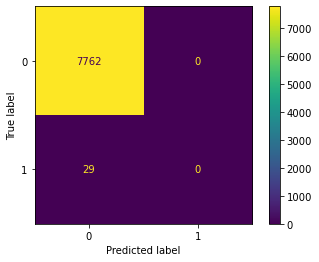

In [69]:
# Instantiating our Dummy Model and fitting it to our training data
dummy_clf = DummyClassifier(strategy='most_frequent')

# Evaluating it 
evaluate(dummy_clf)

### 4.2 Baseline Model - Logistic Regression 

   This will serve as our baseline model to compare the performance of our later model iterations to. 

Recall Score:    0.3793103448275862
Accuracy Score:  0.7529200359389039
Precision Score: 0.005735140771637122


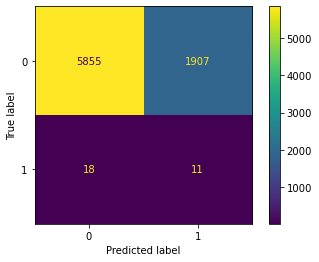

In [70]:
# Instantiating our Logistic Regression Model and evaluating it 
logreg = LogisticRegression(random_state=seed, 
                            class_weight='balanced', 
                            max_iter=10e5)

evaluate(logreg)

### 4.3 K-Nearest Neighbors Model

In [ ]:
# KNN param grid
pg3 = {'n_neighbors': [1, 3, 5, 11],
       'weights': ['uniform', 'distance'],
       'leaf_size': [5, 10, 30]}

# The grid search is commented out to reduce notebook runtime, best parameters are input into tuned_knn

# knn = KNeighborsClassifier()
# tuned_knn = GridSearchCV(clf_3, pg3, cv=5, scoring='recall')
# tuned_knn.fit(X_train_resampled, y_train_resampled)
# print(tuned_knn.best_params_)

Recall Score:    0.034482758620689655
Accuracy Score:  0.9929405724553972
Precision Score: 0.03571428571428571


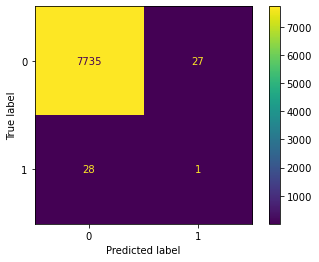

In [71]:
# Making our tuned knn with the parameters output by GridSearch
tuned_knn = (KNeighborsClassifier(n_neighbors = 1, 
                                  leaf_size=10, 
                                  weights='distance'))

# Looking at the results
evaluate(tuned_knn)

### 4.5 Decision Tree

In [ ]:
# Decision Tree parameter grid
pg4 = {'criterion': ['gini'],
       'max_depth':[None],
       'min_samples_split': [2, 10, 100],
       'min_samples_leaf': [1],
       'max_features':[None],
       'max_leaf_nodes':[None, 100],
       'class_weight':['balanced']}

# Grid Search commented out to reduce notebook runtime

# tree = DecisionTreeClassifier(random_state=seed)
# tuned_tree = GridSearchCV(tree, pg4, cv=5, scoring='recall').fit(X_train_resampled, y_train_resampled)
# tuned_tree.fit(X_train_resampled, y_train_resampled)
# print(tuned_tree.best_params_)

Recall Score:    0.06896551724137931
Accuracy Score:  0.9826723142087024
Precision Score: 0.01818181818181818


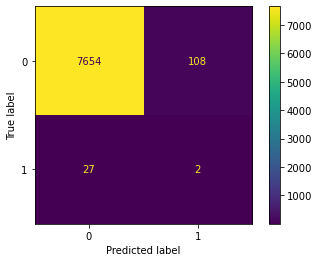

In [72]:
# Manually building tuned_tree, inputting parameters ouput by GridSearch
tuned_tree = DecisionTreeClassifier(class_weight= 'balanced', 
                                    criterion= 'gini',
                                    max_depth= None, 
                                    max_features= None, 
                                    max_leaf_nodes= None, 
                                    min_samples_leaf= 1, 
                                    min_samples_split= 10)

# Checking its accuracy
evaluate(tuned_tree)

### 4.6 Random Forest

In [76]:
pg5 = {'n_estimators' : [10, 100, 250],
       'min_samples_split': [2, 4],
       'min_samples_leaf': [1, 3],
       'max_leaf_nodes': [None, 150],
       'class_weight':['balanced'],}

# The Grid Search is commented out to reduce notebook runtime 

forest = RandomForestClassifier(random_state=seed)
forest_tuner = GridSearchCV(forest, pg5, cv=5, scoring='recall')
# forest_tuner.fit(X_train_resampled, y_train_resampled)
# forest_tuner.best_params_  

{'class_weight': 'balanced',
 'max_leaf_nodes': 150,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 10}

Recall Score:    0.10344827586206896
Accuracy Score:  0.9924271595430625
Precision Score: 0.08333333333333333


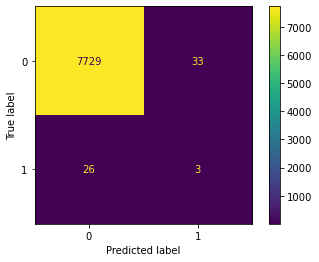

In [96]:
# Manually inputting the results of Grid Search 
tuned_forest = RandomForestClassifier(random_state=seed,
                                      class_weight= 'balanced',
                                      max_leaf_nodes= 150,
                                      min_samples_leaf= 1,
                                      min_samples_split= 4,
                                      n_estimators= 10)
# Evalutation
evaluate(tuned_forest)

## 5. Model Iterations

In [ ]:
# Logistic Regression parameter grid
pg2 = {'penalty': ['l2'],
       'tol' : [.001 ,.0001, .00001],
       'C' : [.003, .001, .0005],
       'class_weight':['balanced'],
       'max_iter':[10e10],
       'solver':['newton-cg', 'lbfgs']
       }

# The grid search is commented out to reduce notebook runtime, best parameters are input into tuned_logreg

logreg = LogisticRegression(random_state=seed)
tuned_logreg = GridSearchCV(logreg, pg2, cv=5, scoring='recall')
tuned_logreg.fit(X_train_encoded, y_train)
print(tuned_logreg.best_params_)
plot_confusion_matrix(tuned_logreg, X_test_encoded, y_test)

## 6. Final Model Evaluation and Analysis